In [103]:
# Package import
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import os
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import talib
from plotly.subplots import make_subplots
import pickle
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
import copy


import warnings

warnings.filterwarnings("ignore")

from functions_TA_indicator import *

In [104]:
pio.templates.default = "plotly_white"
default_template = pio.templates[pio.templates.default]

def clear_output():
    for file in os.listdir():
        if file.endswith('.html'):
            os.remove(file)

clear_output()

In [105]:
with open('Data/Transformed_Data/datasets_v1.pickle', 'rb') as file: 
    ml_dataset = pickle.load(file)


print(ml_dataset["all"]["all"].keys())
ml_dataset["test"]["all"]
    

Index(['Date', 'Open', 'High', 'Low', 'Close', 'AROON_down_3', 'AROON_up_3',
       'AROON_down_6', 'AROON_up_6', 'AROON_down_9',
       ...
       'ROC_18', 'ROC_24', 'ROC_30', 'RSI_3', 'RSI_6', 'RSI_9', 'RSI_12',
       'RSI_18', 'RSI_24', 'RSI_30'],
      dtype='object', length=137)


,Date,Open,High,Low,Close,AROON_down_3,AROON_up_3,AROON_down_6,AROON_up_6,AROON_down_9,...,ROC_18,ROC_24,ROC_30,RSI_3,RSI_6,RSI_9,RSI_12,RSI_18,RSI_24,RSI_30
0,2020-01-02,13.460000,13.720000,12.42,12.47,0.000000,66.666667,33.333333,83.333333,55.555556,...,-14.118458,8.058928,0.080259,30.193183,39.866906,42.927382,44.488843,45.900588,46.512465,46.894977
1,2020-01-03,15.010000,16.200001,13.13,14.02,66.666667,100.000000,16.666667,100.000000,44.444444,...,2.936862,19.319153,9.020224,61.156830,57.518885,55.395951,54.051196,52.309047,51.212375,50.533301
2,2020-01-06,15.450000,16.389999,13.54,13.85,33.333333,100.000000,0.000000,100.000000,33.333333,...,-12.673388,9.746438,8.372462,56.997542,55.379318,53.941882,52.959666,51.599232,50.702496,50.143519
3,2020-01-07,13.840000,14.460000,13.39,13.79,0.000000,66.666667,0.000000,83.333333,22.222222,...,-12.053573,-7.511736,5.026655,55.016633,54.520381,53.385482,52.551059,51.338890,50.517262,50.002699
4,2020-01-08,15.160000,15.240000,12.83,13.45,100.000000,33.333333,33.333333,66.666667,11.111111,...,-10.273516,-15.726818,8.995135,42.470457,49.318838,50.091630,50.158734,49.830397,49.449050,49.192856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918,2023-08-25,17.209999,17.360001,15.45,15.68,100.000000,0.000000,100.000000,16.666667,0.000000,...,12.562814,12.724662,17.541230,31.814872,41.583550,46.282421,48.603706,50.241605,50.381766,50.102303
919,2023-08-28,16.240000,16.280001,15.00,15.08,100.000000,66.666667,100.000000,0.000000,0.000000,...,-6.277192,8.802311,11.869439,24.733733,36.426712,42.197681,45.236947,47.794194,48.504977,48.608998
920,2023-08-29,15.080000,15.300000,14.34,14.45,100.000000,33.333333,100.000000,0.000000,100.000000,...,-9.233670,9.552693,8.646614,18.313786,31.504064,38.213768,41.911475,45.338773,46.602904,47.084655
921,2023-08-30,14.530000,14.700000,13.83,13.88,100.000000,0.000000,100.000000,0.000000,100.000000,...,-18.830410,-3.678000,0.872092,13.543066,27.473158,34.863505,39.076202,43.212040,44.939171,45.742078


## Exploratory target creation phase (Defining peaks and valleys with windows)

Idea: suppose we could look at our entire training dataset, and the corresponding values for low_min and high_max. We could the Define a point as a peak if it is the highest value within a window of size w. We could then define a point as a vally if it is the lowest value within a window of size w.



In [112]:
min_low_df  = pd.read_csv("Data/Original_Data/Min_Low.csv")
min_low_df

,Date,Min_Low_3,Min_Low_6,Min_Low_9,Min_Low_12,Min_Low_18,Min_Low_24,Min_Low_30,Min_Low_36,Min_Low_42,Min_Low_48,Min_Low_54,Min_Low_60
0,2003-01-02,25.320000,25.320000,25.320000,25.320000,25.320000,23.969999,23.049999,23.049999,23.049999,23.049999,23.049999,23.049999
1,2003-01-03,24.680000,24.680000,24.680000,24.680000,24.680000,24.680000,23.049999,23.049999,23.049999,23.049999,23.049999,23.049999
2,2003-01-06,24.290001,24.290001,24.290001,24.290001,24.290001,24.290001,23.049999,23.049999,23.049999,23.049999,23.049999,23.049999
3,2003-01-07,24.290001,24.290001,24.290001,24.290001,24.290001,24.290001,23.049999,23.049999,23.049999,23.049999,23.049999,23.049999
4,2003-01-08,24.290001,24.290001,24.290001,24.290001,24.290001,24.290001,23.620001,23.049999,23.049999,23.049999,23.049999,23.049999
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5197,2023-08-25,15.450000,15.450000,14.910000,14.600000,14.570000,12.740000,12.740000,12.740000,12.740000,12.730000,12.730000,12.730000
5198,2023-08-28,15.000000,15.000000,15.000000,14.770000,14.570000,12.740000,12.740000,12.740000,12.740000,12.730000,12.730000,12.730000
5199,2023-08-29,14.340000,14.340000,14.340000,14.340000,14.340000,12.740000,12.740000,12.740000,12.740000,12.730000,12.730000,12.730000
5200,2023-08-30,13.830000,13.830000,13.830000,13.830000,13.830000,13.270000,12.740000,12.740000,12.740000,12.740000,12.730000,12.730000


In [113]:
max_high_df = pd.read_csv("Data/Original_Data/Max_High.csv")
max_high_df

,Date,Max_High_3,Max_High_6,Max_High_9,Max_High_12,Max_High_18,Max_High_24,Max_High_30,Max_High_36,Max_High_42,Max_High_48,Max_High_54,Max_High_60
0,2003-01-02,30.830000,30.830000,30.840000,30.840000,31.200001,31.200001,31.200001,31.900000,32.599998,34.430000,36.270000,43.439999
1,2003-01-03,29.620001,30.830000,30.830000,30.840000,31.200001,31.200001,31.200001,31.900000,32.599998,33.529999,35.610001,42.580002
2,2003-01-06,28.740000,30.830000,30.830000,30.840000,30.840000,31.200001,31.200001,31.900000,32.599998,33.529999,35.610001,39.389999
3,2003-01-07,25.690001,30.830000,30.830000,30.840000,30.840000,31.200001,31.200001,31.200001,32.599998,33.529999,35.610001,37.180000
4,2003-01-08,25.760000,29.620001,30.830000,30.830000,30.840000,31.200001,31.200001,31.200001,31.900000,32.599998,35.610001,37.180000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5197,2023-08-25,17.360001,18.879999,18.879999,18.879999,18.879999,18.879999,18.879999,18.879999,18.879999,18.879999,18.879999,18.879999
5198,2023-08-28,17.360001,18.110001,18.879999,18.879999,18.879999,18.879999,18.879999,18.879999,18.879999,18.879999,18.879999,18.879999
5199,2023-08-29,17.360001,17.580000,18.879999,18.879999,18.879999,18.879999,18.879999,18.879999,18.879999,18.879999,18.879999,18.879999
5200,2023-08-30,16.280001,17.360001,18.879999,18.879999,18.879999,18.879999,18.879999,18.879999,18.879999,18.879999,18.879999,18.879999


In [114]:
ml_dataset["test"]["all"]

,Date,Open,High,Low,Close,AROON_down_3,AROON_up_3,AROON_down_6,AROON_up_6,AROON_down_9,...,ROC_18,ROC_24,ROC_30,RSI_3,RSI_6,RSI_9,RSI_12,RSI_18,RSI_24,RSI_30
0,2020-01-02,13.460000,13.720000,12.42,12.47,0.000000,66.666667,33.333333,83.333333,55.555556,...,-14.118458,8.058928,0.080259,30.193183,39.866906,42.927382,44.488843,45.900588,46.512465,46.894977
1,2020-01-03,15.010000,16.200001,13.13,14.02,66.666667,100.000000,16.666667,100.000000,44.444444,...,2.936862,19.319153,9.020224,61.156830,57.518885,55.395951,54.051196,52.309047,51.212375,50.533301
2,2020-01-06,15.450000,16.389999,13.54,13.85,33.333333,100.000000,0.000000,100.000000,33.333333,...,-12.673388,9.746438,8.372462,56.997542,55.379318,53.941882,52.959666,51.599232,50.702496,50.143519
3,2020-01-07,13.840000,14.460000,13.39,13.79,0.000000,66.666667,0.000000,83.333333,22.222222,...,-12.053573,-7.511736,5.026655,55.016633,54.520381,53.385482,52.551059,51.338890,50.517262,50.002699
4,2020-01-08,15.160000,15.240000,12.83,13.45,100.000000,33.333333,33.333333,66.666667,11.111111,...,-10.273516,-15.726818,8.995135,42.470457,49.318838,50.091630,50.158734,49.830397,49.449050,49.192856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918,2023-08-25,17.209999,17.360001,15.45,15.68,100.000000,0.000000,100.000000,16.666667,0.000000,...,12.562814,12.724662,17.541230,31.814872,41.583550,46.282421,48.603706,50.241605,50.381766,50.102303
919,2023-08-28,16.240000,16.280001,15.00,15.08,100.000000,66.666667,100.000000,0.000000,0.000000,...,-6.277192,8.802311,11.869439,24.733733,36.426712,42.197681,45.236947,47.794194,48.504977,48.608998
920,2023-08-29,15.080000,15.300000,14.34,14.45,100.000000,33.333333,100.000000,0.000000,100.000000,...,-9.233670,9.552693,8.646614,18.313786,31.504064,38.213768,41.911475,45.338773,46.602904,47.084655
921,2023-08-30,14.530000,14.700000,13.83,13.88,100.000000,0.000000,100.000000,0.000000,100.000000,...,-18.830410,-3.678000,0.872092,13.543066,27.473158,34.863505,39.076202,43.212040,44.939171,45.742078


In [115]:

def show_vertexes(N = 48, W = 45, type_of_vertex = "all", window_placement = "looking_back", show_plot = True):
    """
    N: defines the specific Min_Low_N or Max_High_N to use
    W: defines the window size to use when looking at Min_Low_N_W or Max_High_N_W
    type_of_vertex: "all", "max", "min"
    window_placement: "looking_back", "looking_center" (forward is hacking and you can't do that, that's illegal.)
    """

    global ml_dataset
    global max_high_df
    global min_low_df

    data = ml_dataset["all"]["all"].copy(deep = True)
    data = data.reset_index(drop = True)

    if window_placement == "looking_center":
        data[f'Max_High_{N}_{W}']   = max_high_df[f'Max_High_{N}'].shift(-W//2).rolling(window=W).max()
        data[f'Min_Low_{N}_{W}']    = min_low_df[f'Min_Low_{N}'].shift(-W//2).rolling(window=W).min()

    elif window_placement == "looking_back":
        # Looks back W days
        data[f'Max_High_{N}_{W}']   = max_high_df[f'Max_High_{N}'].rolling(window=W).max()
        data[f'Min_Low_{N}_{W}']    = min_low_df[f'Min_Low_{N}'].rolling(window=W).min()
    else: 
        print("window_placement must be 'looking_back' or 'looking_center'")

    data = data.set_index('Date')
    high_indices = data[(data[f'High'] == data[f'Max_High_{N}_{W}'])].index.tolist()
    low_indices  = data[(data[f'Low'] == data[f'Min_Low_{N}_{W}']) & (data["Low"] < 19)].index.tolist()

    if show_plot:
        trace_close = go.Candlestick(x=data.index,
                            open=data['Open'],
                            high=data['High'],
                            low=data['Low'],
                            close=data['Close'],
                            name='OHLC')

        if type_of_vertex != "min":
            trace_high  = go.Scatter(x=data.index, y=data['High'], mode='lines', name='High', line=dict(color='#3477eb', width=2))
            trace_max   = go.Scatter(x=data.index, y=data[f'Max_High_{N}'], mode='lines', name=f'Max High {N}', line=dict(color='#9EE09E', width=2))
            trace_max_w = go.Scatter(x=data.index, y=data[f'Max_High_{N}_{W}'], mode='lines', name=f'Max High {N}_{W}', line=dict(color='Green', width=2))
        if type_of_vertex != "max":
            trace_low   = go.Scatter(x=data.index, y=data['Low'], mode='lines', name='Low', line=dict(color='#2254ab', width=2))
            trace_min   = go.Scatter(x=data.index, y=data[f'Min_Low_{N}'], mode='lines', name=f'Min Low {N}', line=dict(color='#FF6B6B', width=2))
            trace_min_w = go.Scatter(x=data.index, y=data[f'Min_Low_{N}_{W}'], mode='lines', name=f'Min Low {N}_{W}', line=dict(color='Red', width=2))

        layout = go.Layout(
            title=f"Vertexes: {type_of_vertex}, N={N}, W={W}, {window_placement}",
            xaxis=dict(title='Date', rangeslider=dict(visible=False)),
            yaxis=dict(title='Price', autorange=True),
            template='plotly_white'
        )

        data_viz = []
        if type_of_vertex != "min":
            data_viz = data_viz + [trace_max_w, trace_max, trace_high]
        data_viz = data_viz + [trace_close]
        if type_of_vertex != "max":
            data_viz = data_viz + [trace_low, trace_min, trace_min_w]

        ## ### Adding dots for vertexes
        for index in high_indices + low_indices:
            if index in high_indices and type_of_vertex != "min":
                y_value = data.loc[index, 'High']
                color = 'yellow'
                dot = go.Scatter(x=[index], y=[y_value], mode='markers',
                                 marker=dict(color=color, size=10), showlegend=False)
                data_viz.append(dot)
            elif index in low_indices and type_of_vertex != "max":
                y_value = data.loc[index, 'Low']
                color = "#fa37dd" #'yellow'#'#D9AFFF'
                dot = go.Scatter(x=[index], y=[y_value], mode='markers',
                                 marker=dict(color=color, size=10), showlegend=False)
                data_viz.append(dot)

        fig = go.Figure(data=data_viz, layout=layout)
        fig.show()

    return high_indices, low_indices

high_indices, low_indices = show_vertexes(N = 60, W = 60, type_of_vertex = "max", window_placement = "looking_back")

## Observation on visual analysis for "looking_back"

It appears the when not using data in the future, the peak and vally's continously get redefined.

## Visual Analysis for "looking_center"

Below you can find the visuals for "looking center", which is defined as a window arround $t$, defined by $t-(W/2)$ and $t+(W/2)$

In [116]:

high_indices, low_indices = show_vertexes(N = 60, W = 60, type_of_vertex = "min", window_placement = "looking_center")

In [117]:

high_indices, low_indices = show_vertexes(N = 60, W = 60, type_of_vertex = "max", window_placement = "looking_center")

## Conclusions on "looking center" 

When "looking center", which is a window arround $t$, defined by $t-(W/2)$ and $t+(W/2)$, the peaks and valley's are not redefined. I consider it is a valid approach as the target for a regression task is typically based on a future value. 
As long as the features used to predict the target are not from future values, then this should be a valid approach.

In [118]:

high_indices, low_indices = show_vertexes(N = 18, W = 20, type_of_vertex = "all", window_placement = "looking_center")

In [119]:
def get_high_low_prices(__high_indices, __low_indices, data):
    high_prices = []
    low_prices = []
    for index in __high_indices:
        high_prices.append(data.loc[index, 'High'])
    for index in __low_indices:
        low_prices.append(data.loc[index, 'Low'])
        
    return high_prices, low_prices
    

def get_past_and_future_high(cur_date, __high_prices, __high_indices):
    """ 
    finds the values of the previous high and the future high
    """
    past_high_index = None
    for date_str in __high_indices:
        if date_str >= cur_date:
            past_high_index = __high_indices.index(date_str) - 1
            if past_high_index < 0: 
                past_high_index = 0
            future_high_index = __high_indices.index(date_str)
            break

    if past_high_index == None:
        past_high_index = len(__high_indices) - 1
        future_high_index = past_high_index

    tmp_cur_date = datetime.strptime(cur_date, '%Y-%m-%d')
    tmp_past_high_date   = datetime.strptime(__high_indices[past_high_index], '%Y-%m-%d')
    tmp_future_high_date = datetime.strptime(__high_indices[future_high_index], '%Y-%m-%d')
    
    past_high_distance = abs((tmp_cur_date - tmp_past_high_date).days) # abs to handle the first date.
    future_high_distance = abs((tmp_future_high_date - tmp_cur_date).days) # abs to handle the last date.
    if past_high_distance == 0:
        past_high_distance = 1
    if future_high_distance == 0:
        future_high_distance = 1

    return {"past_high_price" : __high_prices[past_high_index], 
            "future_high_price" : __high_prices[future_high_index],
            "past_high_distance" : past_high_distance,
            "future_high_distance" : future_high_distance}


def get_past_and_future_low(cur_date, __low_prices, __low_indices):
    """ 
    finds the values of the previous low and the future low
    
    """
    past_low_index = None # placeholder
    for date_str in __low_indices:
        if date_str >= cur_date:
            past_low_index = __low_indices.index(date_str) - 1
            if past_low_index < 0: 
                past_low_index = 0
            future_low_index = __low_indices.index(date_str)
            break

    if past_low_index == None:
        past_low_index = len(__low_indices) - 1
        future_low_index = past_low_index

    tmp_cur_date = datetime.strptime(cur_date, '%Y-%m-%d')
    tmp_past_low_date   = datetime.strptime(__low_indices[past_low_index], '%Y-%m-%d')
    tmp_future_low_date = datetime.strptime(__low_indices[future_low_index], '%Y-%m-%d')

    past_low_distance   = abs((tmp_cur_date - tmp_past_low_date).days) # abs to handle the first low
    future_low_distance = abs((tmp_future_low_date - tmp_cur_date).days) # abs to handle the last low
    if past_low_distance == 0:
        past_low_distance = 1
    if future_low_distance == 0:
        future_low_distance = 1

    return {"past_low_price" : __low_prices[past_low_index], 
            "future_low_price" : __low_prices[future_low_index],
            "past_low_distance" : past_low_distance,
            "future_low_distance" : future_low_distance}    


In [120]:
def create_target(__high_indices, __low_indices, verbose = False):
    """
    Creates a target for the ML model to predict.
    The target is defined as the percentage change in the price of the current day, to the average of the previous peak and the future peak.
    The formula is created over several steps for the sake of clarity.

    __high_indices: list of string_dates where the price was at a peak.
    __low_indices: list of string_dates where the price was at a valley.

    return high_targets, low_targets
    """
    
    global ml_dataset
    data = ml_dataset["all"]["all"]
    tmp_OHLC_data = ml_dataset["all"]["all"].copy(deep = True)
    tmp_OHLC_data = tmp_OHLC_data[['Date','Open', 'High', 'Low', 'Close']]
    tmp_OHLC_data = tmp_OHLC_data.set_index('Date')

    __high_prices, __low_prices = get_high_low_prices(__high_indices, __low_indices, tmp_OHLC_data)

    high_targets = []
    low_targets  = []

    if verbose:
        print("__high_indices: ", __high_indices[:8], "...")
        print("__high_prices: ", __high_prices[:8], "...","\n")

    for idx, close_price in enumerate(data['Close']):
        cur_date = tmp_OHLC_data.index[idx]
        high_info_dict = get_past_and_future_high(cur_date, __high_prices, __high_indices)
        low_info_dict = get_past_and_future_low(cur_date , __low_prices, __low_indices)
        
        entry_high_target = ((high_info_dict['future_high_price']* high_info_dict['past_high_distance']
                            + high_info_dict['past_high_price']* high_info_dict['future_high_distance']) / 
                            (high_info_dict['past_high_distance'] + high_info_dict['future_high_distance']))
        if entry_high_target < close_price:
            # This line is specifically targeted for the beginning and the end.
            entry_high_target = close_price

        entry_high_target = close_price/entry_high_target


        entry_low_target  = ((low_info_dict['future_low_price']* low_info_dict['past_low_distance']
                            + low_info_dict['past_low_price']* low_info_dict['future_low_distance']) / 
                            (low_info_dict['past_low_distance'] + low_info_dict['future_low_distance']))
        if entry_low_target > close_price:
            # This line is specifically targeted for the beginning and the end.
            entry_low_target = close_price

        entry_low_target  = entry_low_target/close_price


        high_targets.append(entry_high_target)
        low_targets.append(entry_low_target)

        if verbose and (2520 < idx < 2800) and (idx%50==0) :
            print(f"Idx: {idx:<3} Date: {cur_date}   Close price: {close_price:.2f}   Past high: {high_info_dict['past_high_price']:.2f}   Future high: {high_info_dict['future_high_price']:.2f}   High Target: {entry_high_target:.2f}")
            print("past_high_distance: ", high_info_dict['past_high_distance'] , "  future_high_distance: ", high_info_dict['future_high_distance'])
            print("")

    return high_targets, low_targets


high_targets, low_targets = create_target(high_indices, low_indices, verbose = True)

__high_indices:  ['2003-02-10', '2003-06-09', '2003-08-06', '2003-09-30', '2003-11-20', '2004-03-22', '2004-05-17', '2004-08-09'] ...
__high_prices:  [35.65999984741211, 22.809999465942383, 23.88999938964844, 23.26000022888184, 19.61000061035156, 22.670000076293945, 20.450000762939453, 19.96999931335449] ... 

Idx: 2550 Date: 2013-02-20   Close price: 14.68   Past high: 23.23   Future high: 19.28   High Target: 0.75
past_high_distance:  54   future_high_distance:  5

Idx: 2600 Date: 2013-05-02   Close price: 13.59   Past high: 18.20   Future high: 21.91   High Target: 0.72
past_high_distance:  14   future_high_distance:  53

Idx: 2650 Date: 2013-07-15   Close price: 13.79   Past high: 21.91   Future high: 17.81   High Target: 0.67
past_high_distance:  21   future_high_distance:  46

Idx: 2700 Date: 2013-09-24   Close price: 14.08   Past high: 17.81   Future high: 21.34   High Target: 0.70
past_high_distance:  25   future_high_distance:  15

Idx: 2750 Date: 2013-12-04   Close price: 14.

### Updating the ml_dataset object to include target keys

In [121]:
tmp_all_df = ml_dataset["all"]["all"].copy(deep = True)
tmp_all_df = tmp_all_df[['Date','Open', 'High', 'Low', 'Close']]
tmp_all_df["High_Target"] = high_targets
tmp_all_df["Low_Target"] = low_targets
tmp_all_df["Diff_Target"] = tmp_all_df["High_Target"] - tmp_all_df["Low_Target"]
ml_dataset["all"]["target"] = tmp_all_df
ml_dataset["all"]["target"] = ml_dataset["all"]["target"][['Date','High_Target', 'Low_Target', 'Diff_Target']]

tmp_targets_only = ml_dataset["all"]["target"][['Date','High_Target', 'Low_Target', 'Diff_Target']]
tmp_targets_only

for range_type in ["train", "val", "test"]:
    ml_dataset[range_type]["target"] = ml_dataset[range_type]["all"][['Date','Open', 'High', 'Low', 'Close']]
    ml_dataset[range_type]["target"] = ml_dataset[range_type]["target"].merge(tmp_targets_only, on = "Date", how = "left")
    ml_dataset[range_type]["target"] = ml_dataset[range_type]["target"][['Date','High_Target', 'Low_Target', 'Diff_Target']]
    ml_dataset[range_type]["target"].reset_index(drop = True, inplace = True)

with open('Data/Transformed_Data/datasets_v2.pickle', 'wb') as file: 
    pickle.dump(ml_dataset, file, protocol=pickle.HIGHEST_PROTOCOL)

ml_dataset["train"]["target"]

,Date,High_Target,Low_Target,Diff_Target
0,2003-01-02,0.712002,0.718393,-0.006391
1,2003-01-03,0.692092,0.739060,-0.046968
2,2003-01-06,0.698542,0.732236,-0.033694
3,2003-01-07,0.704711,0.725826,-0.021115
4,2003-01-08,0.715928,0.714454,0.001475
...,...,...,...,...
3771,2017-12-22,0.384081,0.905929,-0.521848
3772,2017-12-26,0.367273,0.880691,-0.513417
3773,2017-12-27,0.368124,0.863579,-0.495455
3774,2017-12-28,0.351342,0.889614,-0.538272


In [122]:

def visualize_target(viz_type = "both"):
    """
    Args:
        viz_type (str, optional): "both" or "difference".
    """


    global ml_dataset
    global high_indices
    global low_indices


    data = ml_dataset["all"]["target"].copy(deep = True)
    data = data.merge(ml_dataset["all"]["all"][['Date','Open', 'High', 'Low', 'Close']], on = "Date", how = "left")
    data.set_index('Date', inplace = True)


    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=('OHLC', 'High/Low Targets'),
                        vertical_spacing=0.1)

    trace_close = go.Candlestick(x=data.index,
                                open=data['Open'],
                                high=data['High'],
                                low=data['Low'],
                                close=data['Close'],
                                name='OHLC')

    fig.add_trace(trace_close, row=1, col=1)

    if viz_type == "both":
        trace_targets_low = go.Scatter(x=data.index,
                                    y=data['Low_Target'], 
                                    mode='lines',
                                    name='Low Target')
        fig.add_trace(trace_targets_low, row=2, col=1)

        trace_targets = go.Scatter(x=data.index,
                                y=data['High_Target'],  
                                mode='lines',
                                name='High Target')
        fig.add_trace(trace_targets, row=2, col=1)

    else:
        trace_targets = go.Scatter(x=data.index,
                                y=data['Diff_Target'],
                                mode='lines',
                                name='Diff Target')

        fig.add_trace(trace_targets, row=2, col=1)

    for index in high_indices + low_indices:
        
        if index in high_indices:
            y_value = data.loc[index, 'High']
            color = 'yellow'
            dot = go.Scatter(x=[index], y=[y_value], mode='markers',
                                marker=dict(color=color, size=10), showlegend=False)
            fig.add_trace(dot, row=1, col=1)

        elif index in low_indices:
            y_value = data.loc[index, 'Low']
            color = "#fa37dd" #'yellow'#'#D9AFFF'
            dot = go.Scatter(x=[index], y=[y_value], mode='markers',
                                marker=dict(color=color, size=10), showlegend=False)
            fig.add_trace(dot, row=1, col=1)

    fig.update_layout(
        title=f"Targets, High and Low points",
        xaxis2=dict(title='Date', rangeslider=dict(visible=True)),  
        yaxis=dict(title='Price', autorange=True),
        template='plotly_white'
    )

    fig.update_xaxes(rangeslider=dict(visible=False), row=1, col=1)  

    fig.show()

visualize_target()

In [123]:
visualize_target(viz_type = "difference")

# Testing a simple Regression Decision Tree on the new target (Only OHLC)

In [124]:
train = ml_dataset["train"]["all"][['Date','Open', 'High', 'Low', 'Close']]
val   = ml_dataset["val"]["all"][['Date','Open', 'High', 'Low', 'Close']]
test  = ml_dataset["test"]["all"][['Date','Open', 'High', 'Low', 'Close']]

data = pd.concat([train, val]).reset_index(drop=True)
y_data = pd.concat([ml_dataset["train"]["target"], ml_dataset["val"]["target"]]).reset_index(drop=True)

data_dates = data['Date'].copy(deep = True)
X_data = data.drop(columns=['Date'])
y_data = y_data.drop(columns=['Date'])

test_dates = test['Date'].copy(deep = True)
X_test = test.drop(columns=['Date'])
y_test = ml_dataset["test"]["target"].copy(deep = True).drop(columns=['Date'])


In [125]:

model = DecisionTreeRegressor()

tscv = TimeSeriesSplit(n_splits=10)
results = {
    "train_mse": [],
    "val_mse": [],
    "train_mae": [],
    "val_mae": [],
    "train_mape": [],
    "val_mape": []
}

for train_index, val_index in tscv.split(X_data):
    X_train, X_val = X_data.iloc[train_index], X_data.iloc[val_index]
    y_train, y_val = y_data.iloc[train_index], y_data.iloc[val_index]

    model.fit(X_train, y_train)
    
    predictions = model.predict(X_val)
    
    train_predictions = model.predict(X_train)
    
    results["train_mse"].append(mean_squared_error(y_train, train_predictions))
    results["val_mse"].append(mean_squared_error(y_val, predictions))
    
    results["train_mae"].append(mean_absolute_error(y_train, train_predictions))
    results["val_mae"].append(mean_absolute_error(y_val, predictions))
    
    results["train_mape"].append(np.mean(np.abs((y_train - train_predictions) / y_train)) * 100)
    results["val_mape"].append(np.mean(np.abs((y_val - predictions) / y_val)) * 100)


final_results = {key: (np.mean(val), np.std(val)) for key, val in results.items()}
for key in final_results:
    print(f"{key}: {final_results[key][0]:.3f} +/- {final_results[key][1]:.3f}")


train_mse: 0.000 +/- 0.000
val_mse: 0.035 +/- 0.006
train_mae: 0.000 +/- 0.000
val_mae: 0.143 +/- 0.015
train_mape: 0.000 +/- 0.000
val_mape: 127.017 +/- 192.877


In [126]:
X_data

,Open,High,Low,Close
0,28.740000,28.740000,25.320000,25.389999
1,25.549999,25.549999,24.680000,24.680000
2,25.320000,25.420000,24.290001,24.910000
3,25.129999,25.690001,24.910000,25.129999
4,25.620001,25.760000,25.070000,25.530001
...,...,...,...,...
4274,12.650000,12.840000,12.560000,12.670000
4275,12.740000,12.750000,11.720000,12.650000
4276,12.610000,13.720000,11.890000,13.430000
4277,13.740000,15.140000,13.440000,14.820000


In [127]:
model.fit(X_data, y_data)

y_test[["Pred_High","Pred_Low","Pred_Diff"]] = model.predict(X_test)  # Adjust based on your actual test dataset structure
y_test['Pred_High_Diff'] = y_test['High_Target'] - y_test['Pred_High']
y_test['Pred_Low_Diff'] = y_test['Low_Target'] - y_test['Pred_Low']
y_test['Pred_Diff_Diff'] = y_test['Diff_Target'] - y_test['Pred_Diff']



In [128]:
target_type = "High"

y_test['Date'] = test_dates
fig = px.line(y_test, x='Date', y=[f'Pred_{target_type}', f'{target_type}_Target', f'Pred_{target_type}_Diff'])
fig.show()

corr_coef_ohlc_high = y_test[["Pred_High", "High_Target"]].corr()
corr_coef_ohlc_low = y_test[["Pred_Low", "Low_Target"]].corr()
corr_coef_ohlc_diff = y_test[["Pred_Diff", "Diff_Target"]].corr()

print(ml_dataset["all"]["all"].keys())

Index(['Date', 'Open', 'High', 'Low', 'Close', 'AROON_down_3', 'AROON_up_3',
       'AROON_down_6', 'AROON_up_6', 'AROON_down_9',
       ...
       'ROC_18', 'ROC_24', 'ROC_30', 'RSI_3', 'RSI_6', 'RSI_9', 'RSI_12',
       'RSI_18', 'RSI_24', 'RSI_30'],
      dtype='object', length=137)


# Testing a simple Regression Decision Tree on the new target (All features (Non-standardized))

In [129]:
train = ml_dataset["train"]["all"]
val   = ml_dataset["val"]["all"]
test  = ml_dataset["test"]["all"]

data = pd.concat([train, val]).reset_index(drop=True)
y_data = pd.concat([ml_dataset["train"]["target"], ml_dataset["val"]["target"]]).reset_index(drop=True)

data_dates = data['Date'].copy(deep = True)
X_data = data.drop(columns=['Date'])
y_data = y_data.drop(columns=['Date'])

test_dates = test['Date'].copy(deep = True)
X_test = test.drop(columns=['Date'])
y_test = ml_dataset["test"]["target"].copy(deep = True).drop(columns=['Date'])


In [130]:

model = DecisionTreeRegressor()

tscv = TimeSeriesSplit(n_splits=10)
results = {
    "train_mse": [],
    "val_mse": [],
    "train_mae": [],
    "val_mae": [],
    "train_mape": [],
    "val_mape": []
}

for train_index, val_index in tscv.split(X_data):
    X_train, X_val = X_data.iloc[train_index], X_data.iloc[val_index]
    y_train, y_val = y_data.iloc[train_index], y_data.iloc[val_index]

    model.fit(X_train, y_train)
    
    predictions = model.predict(X_val)
    
    train_predictions = model.predict(X_train)
    
    results["train_mse"].append(mean_squared_error(y_train, train_predictions))
    results["val_mse"].append(mean_squared_error(y_val, predictions))
    
    results["train_mae"].append(mean_absolute_error(y_train, train_predictions))
    results["val_mae"].append(mean_absolute_error(y_val, predictions))
    
    results["train_mape"].append(np.mean(np.abs((y_train - train_predictions) / y_train)) * 100)
    results["val_mape"].append(np.mean(np.abs((y_val - predictions) / y_val)) * 100)


final_results = {key: (np.mean(val), np.std(val)) for key, val in results.items()}
for key in final_results:
    print(f"{key}: {final_results[key][0]:.3f} +/- {final_results[key][1]:.3f}")


train_mse: 0.000 +/- 0.000
val_mse: 0.022 +/- 0.007
train_mae: 0.000 +/- 0.000
val_mae: 0.109 +/- 0.018
train_mape: 0.000 +/- 0.000
val_mape: 104.774 +/- 172.539


### Decision tree performance on the new target (OHLC)

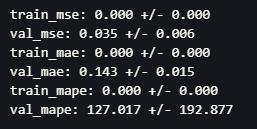

### Decision tree performance on the new target (All features (Non-standardized))

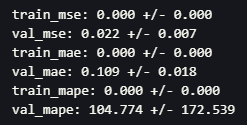

### Decision tree performance assessment

Wow would you look at that. Features for a simple decision tree did help. I wonder how it will perform with LSTM's...

In [133]:
try:
    X_test.drop(columns = ["Pred_High","Pred_Low","Pred_Diff"], inplace = True)
except: 
    pass


model.fit(X_data, y_data)

y_test[["Pred_High","Pred_Low","Pred_Diff"]] = model.predict(X_test)  
y_test['Pred_High_Diff'] = y_test['High_Target'] - y_test['Pred_High']
y_test['Pred_Low_Diff'] = y_test['Low_Target'] - y_test['Pred_Low']
y_test['Pred_Diff_Diff'] = y_test['Diff_Target'] - y_test['Pred_Diff']


In [134]:
target_type = "High" 

y_test['Date'] = test_dates
fig = px.line(y_test, x='Date', y=[f'Pred_{target_type}', f'{target_type}_Target', f'Pred_{target_type}_Diff'])
fig.show()

corr_coef_all_high = y_test[["Pred_High", "High_Target"]].corr()
corr_coef_all_low  = y_test[["Pred_Low", "Low_Target"]].corr()
corr_coef_all_diff = y_test[["Pred_Diff", "Diff_Target"]].corr()

print(ml_dataset["all"]["all"].keys())

Index(['Date', 'Open', 'High', 'Low', 'Close', 'AROON_down_3', 'AROON_up_3',
       'AROON_down_6', 'AROON_up_6', 'AROON_down_9',
       ...
       'ROC_18', 'ROC_24', 'ROC_30', 'RSI_3', 'RSI_6', 'RSI_9', 'RSI_12',
       'RSI_18', 'RSI_24', 'RSI_30'],
      dtype='object', length=137)


In [135]:
try:
    corr_coef_ohlc_high = corr_coef_ohlc_high.iloc[0,1] 
    corr_coef_ohlc_low = corr_coef_ohlc_low.iloc[0,1]
    corr_coef_ohlc_diff = corr_coef_ohlc_diff.iloc[0,1]
    corr_coef_all_high = corr_coef_all_high.iloc[0,1]
    corr_coef_all_low = corr_coef_all_low.iloc[0,1]
    corr_coef_all_diff = corr_coef_all_diff.iloc[0,1] 
except: 
    pass


fig = go.Figure(data=[
    go.Bar(name='OHLC', x=['High', 'Low', 'Diff'], y=[corr_coef_ohlc_high, corr_coef_ohlc_low, corr_coef_ohlc_diff]),
    go.Bar(name='All', x=['High', 'Low', 'Diff'], y=[corr_coef_all_high, corr_coef_all_low, corr_coef_all_diff])
])
fig.update_layout(barmode='group', title = "Correlation Coefficients of Targets and Predictions, grouped by feature data", height = 500)
fig.show()

